In [1]:
import os
import IPython
import matplotlib
import matplotlib.pyplot as plt
import requests
import torch
import torchaudio

In [2]:
print(torch.__version__)

2.3.0+cu121


In [3]:
# SPEECH_URL = "https://keithito.com/LJ-Speech-Dataset/LJ025-0076.wav"
SPEECH_FILE = "speech.wav"
if not os.path.exists(SPEECH_FILE):
    # os.makedirs("_assets", exist_ok=True)
    with open(SPEECH_FILE, "wb") as file:
        file.write(requests.get(SPEECH_URL).content)

In [4]:
IPython.display.Audio(SPEECH_FILE)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print(f"Sample Rate: {bundle.sample_rate}")
print(f"Labels: {bundle.get_labels()}")
model = bundle.get_model().to(device)
print(model.__class__)

Using device cpu
Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')
<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [ ]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)
if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [ ]:
with torch.inference_mode():
    emission, _ = model(waveform)

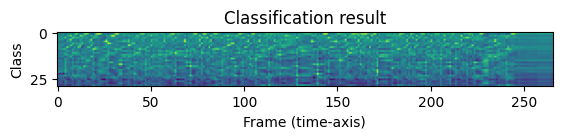

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [ ]:
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

In [ ]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
        emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.
        Returns:
        str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1) # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [ ]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])
transcript

'HEADING|HIS|TWO|SICK|LYRO|TORGET|IS|BLACK|WHITE|AND|YELLOW|CORSAL|AIR|CRAP|TOOL|TO|TEPOY|IS|CIRCUS|AIRMISTLES|'